# Machine Learning in Python - Project 1

*Contributors: Rachel Dance, Silvia Cecilia Hernandez Vargas, Finlay Young*

# Setup
The following packages are required to run this notebook

In [ ]:
# Install required packages
!pip install -q -r requirements.txt

In [ ]:
# Modules to install: 
# Display plots inline
%matplotlib inline 

#Import Functions file to avoid code in notebook
import ml_functions

# Data libraries
import pandas as pd
import numpy as np
from numpy.random import uniform

import copy
from fuzzywuzzy import process
from fuzzywuzzy import fuzz

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer


# Introduction

Analysis of the provided data describing NBC Universal's series 'The Office' is performed to provide advice to NBC Universal, on the factors important to the success of a special reunion episode. No other datasets were included. Herein, we refer to 'the_office.csv' as the data. The data extracted for this analysis is available publicly. Each of the columns of the data are referred to as 'features', e.g. episode name, number of votes, list of main characters appearing etc.

The feature 'imdb_rating' will be used as a proxy for success or popularity of an episode that NBC seeks to maximise. Therefore, we are interested in features that are most predictive of imdb_rating. To begin extracting this insight, a short data exploration is carried out in Section 2. We also recognise that there is an important relationship between imdb_rating and total_votes, as we not only want the episode to be highly rated, but viewed/voted on by a large number of people (e.g. an episode rated 10/10 by 2 people is not considered 'successful'). However, as the average number of votes for these episodes is 2100, with a minimum 1394, we are not too concerned by this.

Both linear and polynomial regression models are used trialled here, with Lasso and Ridge regularisation techniques to shrink the dataset. These techniques highlight features that do not have high impact on imdb_rating, so they can be removed.

We saw that the most predictive of our models was linear regression, in which we used lasso regularisation to carry out variable selection. Features that have been removed before modeling are detailed in Section 2, and model results in Section 4 describe the relative importance of those that remain. These form the basis of our recommendations. Analysis found that episode number and total votes are significant to the popularity, as measured by our proxy. However, these are not under the control of NBC, and as such will not form part of our recommendations. Key recommendations for the production of a reunion episode are summarised as follows:

1. In addition to Dwight, Jim, Pam and Kevin (characters who have appeared in every episode), NBC should also include Kelly, Michael and Andy, given in this order of importance. 
2. Include short but more constant lines between characters. Small positive impact can occur by including more characters in the episode, but we do not recommend to include Ryan or Angela.
3. Ensure Charles McDougall and/or Greg Daniels direct the show. 
4. A short special edition Series would be more benificial than one single episode. 
5. The episode should air in September, and on a Thursday. 

In [ ]:
df = pd.read_csv('the_office.csv')

ml_functions.typo_cleaner('director',df)
ml_functions.typo_cleaner('writer',df)

/work/ml_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name][i] = matches[1][0]
Typo cleaner finished - if no other output, no changes were made
Typo cleaner finished - if no other output, no changes were made


In [ ]:
df_split_test = copy.deepcopy(df)
# Split the main_chars col into individuals and 
for i in range(len(df_split_test['main_chars'])):
    df_split_test['main_chars'][i] = df_split_test['main_chars'][i].split(';')

#split the actors into columns (dummies)
character_cols = df_split_test.main_chars.apply(lambda x: pd.Series([1] * len(x), index=x)).fillna(0, downcast='infer')

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


# Exploratory Data Analysis and Feature Engineering

## Data cleaning

#### Typos:
The data provided is publicly available, and as expected, there are some discrepancies. In order to have a 'correct' dataset as possible, we used "fuzzywuzzy" [https://pypi.org/project/fuzzywuzzy] to correct typos in the names of the directors & writers. From inspection, some names had one letter incorrect, which was causing them to be seen by the dataframes as a separate unique name, causing double counting. Using fuzzywuzzy, we produced a statistic on how good one name matches other names in the data. On this basis, we are able to identify errors based on the following assumptions:

1. Each erroneous name is no less than a 90% match to its closest match.
2. Erroneous names appear exactly once.
3. We do not run this typo cleaner on entries that contain ';' as this corresponds to entries where multiple names are listed.

For our purposes, this captures all of our typos, although we respect that this may not work for every data set - particularly assumption 2. Two other methods were also considered and rejected:

1. Web scraping (of Google & imdb) - if a name posesses a personal page on imdb website which contains an exact match to the spelling of that name, then the name is legitimately a writer or director. This was eliminated on two counts: (1) sheer complexity of returning *accurate* results, and (2) the *correct* names of other directors/actors etc matching the *incorrect* ones in our dataset, e.g. Charles McDougal and Charles McDougall are both legitimate names.

2. Compare with additional imdb data: "name.basics.tsv.gz" at (https://datasets.imdbws.com/), updated daily - we can compare our names to entries on a list of all possible names in imdb. However, this was eliminated on two counts: (1) the dataset was 700MB and computationally infeasible, and (2) the file is also authored by imdb and is likely to *also* contain the error we are trying to find so comparison saw no results.

The "typo_cleaner" function can be fully inspected in the ml_functions.py file. 

#### Main Characters Column: 
The column in the data where main charachters in an episode are listed is formatted as a single string, e.g. "Andy;Angela;Dwight;Jim;Michael;Pam;Phyllis;Stanley". This is not indexable so this was split into a 'list of lists', where unique names were identified and dummy columns were created to show whether or not a character appeared in an episode. This effectively performs the 'pandas.get_dummies()' method on all unique entries in all of the lists concurrently. 

## Exploratory Analysis

### Initial analysis pairplot interpretation. 

As a first step, a pairplot was created on the whole dataset as recieved to inspect any possible features which might have a relation with each other, specially for the variable for interest. The pairplot has been omitted as it was only used as a first indication of underlying trends and did not influence the modelling in any tangible way. 


### Ratings skew with season

As the show has aired for 9 seasons, we can see from the data that the average rating has decreased (see red crossed data point) since season 4, where the average peaked >8.5, however this also comes with a vast increase in the varience of ratings given per episode, and reduction in the number of total votes submitted per episode. This is likely due to the popularity of the show itself, and therefore attracting a wider audience. From this observation, we do not expect the "season" feature itself to have an influence on predicting a high rating episode: as we can see here the last season has some of the highest number of votes received, but still a low average rating. Also, any additonal episode(s) will be part of the next sequencial season. 

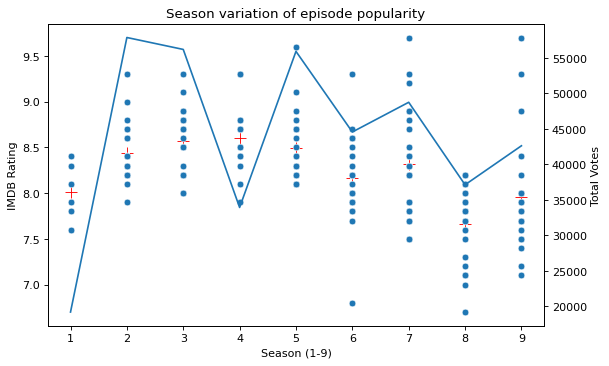

In [ ]:
ml_functions.season_plot(df)

On this basis, the season feature has been removed from data. A prediction that the most popular episodes in a particular season may be present in the data, but holds no predictive power for this application. We have chosen to keep the episode number feature as this may indicate to producers whether an episode is likely to be successful following a small or large number of episodes.

## Categorial data


### Peoples Names

There are 3 text columns which are lists of names, and these did not feature in a pairplot analysis. To quantify characters, writers and directors we will apply one hot encoding to allow us to assess these as separate features. This will allow for the study progress with eliminating writers, characters and directors at a feature level.

### Episode names

Further, we have episode names which could potentially be explored using a 'bag of words' analysis to classify episodes into sucessful or not (based on an imdb rating threshold). 
We could also explore the influence of verbs, nouns or adjectives. However, in this study we are are not going to do such analysis, as each of the episodes names is unique and is unlikely to be predictive in itself. Therefore, we drop the column in further analysis.

### Directors & writers

There are a large number of episodes which were written or directed by multiple people in collabouration with one another. Also, as seasons go on, some new writers/directors appear. 

There are many unique writers and directors, and some combinations in the data set, i.e. on one episode, director A and director B worked together. As it is impossible to determine the influence of the individual in these cases as we do not who 'who did what', it is assumed here that director AB is a different 'person', and extra credit is not givento directors A and B individually. This further ensures that only one director is attributed to any episode. 
In order to work with finding out whether a writer or director is correlated with an increasing imdb rating, more than one data point is needed. As such, we have chosen to omit from the data, any writer or director that appears only once.

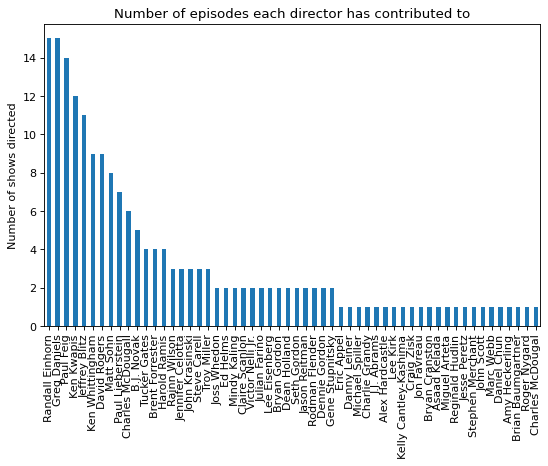

In [ ]:
ml_functions.director_episode_plot(df)

## Feature Engineering

### Sparse data points

Data which appears sparsely represents a rare event. In the instance where a director (say) is seen only once, they will only appear in *either* the training or the test data, and in only one of the folds where a k-fold method is used. This may reduce the accuracy of the modelling, and also is not deemed to provide any predictive insight. As such, any writer director or character that appears only once in the dataset is removed from the data, as part of feature reduction. 

Further, as it is not possible to draw any correlation between two variables with less than (realistically) 5 datapoints, any writer, director or character that appears less than 5 times is also removed due to lack of predictive power.

### Other non predictive data points

Conversely, we also observe that some features occur in the data for *every* episode. For example, the character 'Dwight' appears in every episode. A feature that appears in all episodes cannot provide any predictive power, as it represents a constant feature that will not correlate with others.
We have extended this notion and eliminated directors, characters and writers that appear in 95% or *more* of the episodes (i.e. they appear in >176 episodes our of 186) by a similar justification that this also represents a 'constant' features, and any predictive insight is unlikely.
On this basis we delete: the charaters Dwight,Jim,Pam & Kevin. 

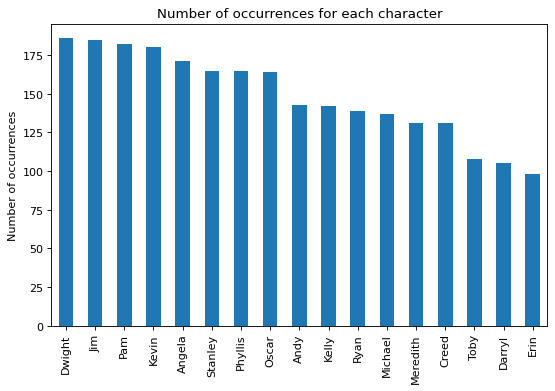

In [ ]:
ml_functions.character_occurrences(df)

### Correlation Matrices

The following correlation matrices are used to give an insight into which features to drop from the model by looking at the correlation between features and imdb_rating, not features with themselves or each other. The matrix below illustrates correlation of our numeric data with imdb_rating.

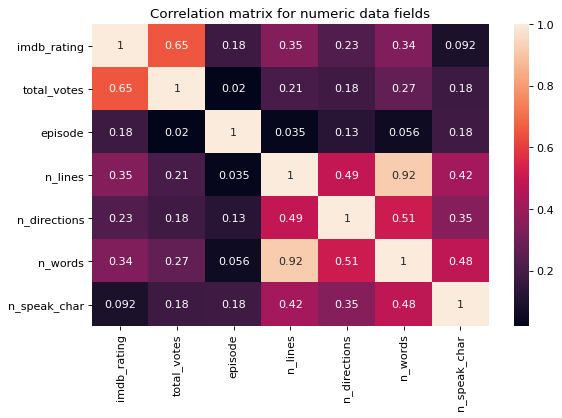

In [ ]:
ml_functions.create_corr_matrix_numeric(df)

Based on this matrix, we did not remove any features as all values are not close to zero. It also indicates that total_votes and n_lines will be important.

#### Correlation matrix - characters

The matrix below shows the relationship between imdb_rating and the characters. We can immediately see that the character Dwight appears in all episodes, and this is the only character to do this. We also observe that characters Jim, Pam, and Kevin have correlation values close to zero. This indicates they will have little or no influence on the imdb_rating, and these four are removed. Character Erin also appears to have a negative correlation with imdb_rating, and is expected to have a negative impact on popularity.

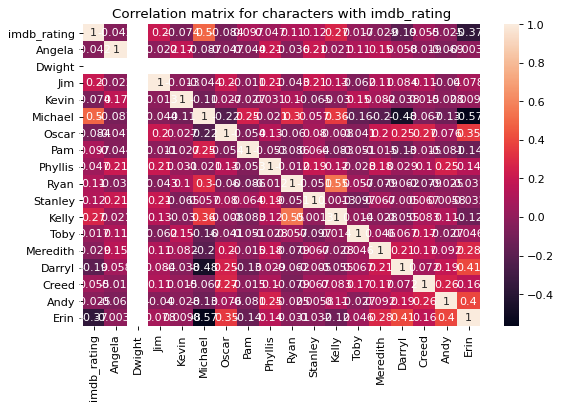

In [ ]:
ml_functions.create_corr_matrix_characters(df,character_cols)

#### Correlation Matrices - writer/director

In this final correlation matrix we consider writers and directors that appear 5 or more times. This matrix shows broadly that the effect of the writer or director with imdb_rating is small. We see the largest positive contribution to the rating is from the director Paul Feig, and for writers Greg Daniels and Charlie Gandy. Only the matrix for 'director' is displayed for brevity.

In [ ]:
# Function to create a list of writers and directors to delete
to_elim_dirs, to_elim_writers = ml_functions.elim_writers_directors(df_split_test)

# Final list of columns to eliminate in feature engineering steps
to_elim = to_elim_writers + to_elim_dirs + ['Dwight','Jim','Pam','Kevin'] 

# Concatenate the columns
df_full = ml_functions.create_df_full(df_split_test, character_cols)
# Concatenate the dataframes where actors are already split, remove duplicates 
df_full_dummies = pd.get_dummies(df_full)
df_model_data = df_full_dummies.drop(to_elim, axis=1)


/work/ml_functions.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_dirs['director'] = 'director_' + single_dirs['director'].astype(str)
/work/ml_functions.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_writers['writer'] = 'writer_' + single_writers['writer'].astype(str)


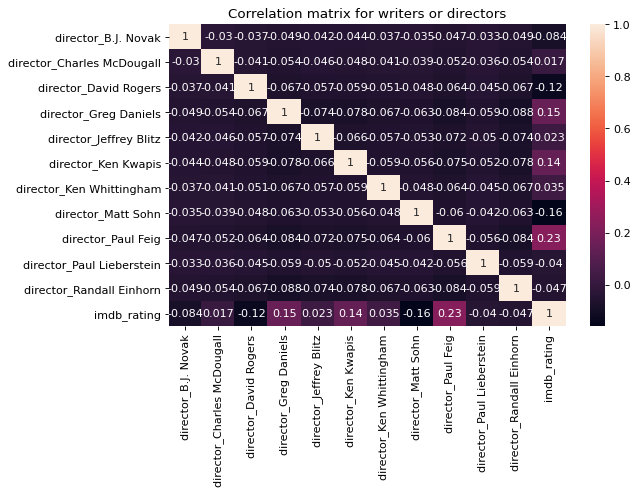

In [ ]:
ml_functions.create_corr_matrix_writers(df_model_data, writer_director='director')

### View Date
The feature 'air_date' was used to extract the month, and day of the week when an episode was aired, to gain a deeper understanding of time-dependency of episode release. We added these as features, and removed the 'air_date' in its original form.


## Conclusions for Feature Engineering

Based on the steps described, we have chosen to proceed with the modelling using a baseline dataset containing all of our features, and a reduced dataset using the feature engineering steps described above. This reduced dataset helps us eliminate potential noise data. *To produce a list of eliminated fields, simply run: 'to_elim' in a cell.*

# Model Fitting and Tuning

## Model Choices

A priori, we know that by their nature, regression trees are not a good choice for achieveing high accuracy in a linear regression setting. Therefore we concentrated only testing the linear and polynomial regression models. We additionally used Lasso and Ridge regularisation techniques. 

## Linear regression
Initially, two linear regression models were constructed, one of which included standardisation. This latter model was eliminated as it produced an RMSE of >8, negative predicted ratings and extreme scoring values. Therefore we will only consider the standard Linear regression model.

In [ ]:
# For the feature engineered dataset (reduced):
lin_reg, lin_reg_train,rmse_train_lin_reg,rmse_test_lin_reg = ml_functions.run_linear_regression(df_model_data, show_output = False)
# For the whole dataset:
lin_reg_full, lin_reg_train_full, rmse_train_lin_reg_full, rmse_test_lin_reg_full = ml_functions.run_linear_regression(df_full_dummies, show_output = True)

We saw from these models that many coefficients are very close to zero, indicating that there are lots of irrelevant features, and that this model should be rejected.

## Polynomial 

### Polynomial Regression with no interaction

Each of the numerical features within this model were processed as polynomial features without interactions, as we assume independence of features and therefore interactions would make no conceptual sense, or contribute to the model. Polynomial processing was only applied to numerical fields, and not to binomial data (such as whether a particular character appears or not).

In [ ]:
# For feature engineered dataset (reduced)
poly_reg_noint, poly_reg_noint_train,rmse_train_poly_reg_noint, rmse_test_poly_reg_noint = ml_functions.run_poly_noint(df_model_data, show_output = False)
# For whole dataset:
poly_reg_noint_full, poly_reg_noint_train_full, rmse_train_poly_reg_noint_full, rmse_test_poly_reg_noint_full = ml_functions.run_poly_noint(df_full_dummies, show_output = False)

### Regular Polynomial regression

When we include feature interaction, we only slightly outperform the non-interaction model (lower RMSE). However, the differences are so small, showing that interaction terms have little impact. Both polynomial models are consistent with the suggestion that a polynomial degree of 1 is the best fit for the model. This further indicates that linear regression is preferred.

In [ ]:
# For feature engineered dataset (reduced)
poly_reg, poly_reg_train, rmse_train_poly_reg, rmse_test_poly_reg = ml_functions.run_polynomial_regression(df_model_data, show_output = False)
# For whole dataset:
poly_reg_full, poly_reg_train_full, rmse_train_poly_reg_full, rmse_test_poly_reg_full = ml_functions.run_polynomial_regression(df_full_dummies, show_output = False)

## Regularisation 

### Ridge Regression
Compared to linear and polynomial models, we see a reduction in RMSE when Ridge was applied. All binomial features have similar magnitude, and this appears to add noise  as none of the feature weights are reduced to exactly zero, and they are all included in the final model. This indicates that a Lasso model will provide further improvement.

In [ ]:
# For feature engineered dataset (reduced)
poly_reg_ridge, poly_reg_ridge_train, rmse_train_poly_reg_ridge, rmse_test_poly_reg_ridge = ml_functions.run_ridge_(df_model_data, show_output = False)
# For the whole dataset: 
poly_reg_ridge_full, poly_reg_ridge_train_full, rmse_train_poly_reg_ridge_full, rmse_test_poly_reg_ridge_full = ml_functions.run_ridge_(df_full_dummies, show_output = False)

### Lasso Polynomial
*The lasso model code is provided here first as this was chosen to be our final model.*
In this model, regression weights that are not significant in prediction are set to zero. Therefore to produce final results, the model uses only a subset of inputs. 

In [ ]:
def run_lasso_(dataframe, show_output:bool):
    '''
    Runs polynomial regression with Lasso regularization, including predictions for the test data.

    Inputs:
        dataframe == pandas dataframe on which to run lasso model
        show_output == boolean set to true or false; true gives terminal
                        and plotting outputs
    Returns:
        third_grid == results from GridSearch Cross-validation
        rmse_train == RMSE from train data
        rmse_test  == RMSE from test data
        results == dataframe containing the true values, estimated values and residuals (from test data)
        results_train == == dataframe containing the true values, estimated values and residuals (from train data)
    '''    
    X_train, X_test, y_train, y_test = ml_functions.dataframe_prep(dataframe,'imdb_rating')

    alpha_list = np.linspace(0.01, 15, num=100)
    third = make_pipeline(
            StandardScaler(),
            PolynomialFeatures(),
            Lasso(fit_intercept= False))

    parameters = {'polynomialfeatures__degree': np.arange(1,3,1),
        'lasso__alpha': alpha_list}

    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    third_grid = GridSearchCV(third, parameters, cv=kf, scoring="neg_root_mean_squared_error").fit(X_train, y_train)
    
    y_hat = third_grid.predict(X_test)
    y_hat_train = third_grid.predict(X_train)

    ml_functions.model_fit(third_grid, X_test, y_test, plot = show_output)
    rmse_test = mean_squared_error(y_test, y_hat, squared=False)
    rmse_train = mean_squared_error(y_train, y_train, squared=False)
    
    results = pd.DataFrame(data = {'y': y_test, 'y_hat': y_hat, 
                                    'resid': round(y_test - y_hat,1)})
    results_train = pd.DataFrame(data={'y_train': y_train, 'y_hat_train': y_hat_train})
    
    if show_output == True:
        print("best param: ", third_grid.best_params_)
        print("best score: ", third_grid.best_score_ *-1)
        print("number of coefficients:",len(third_grid.best_estimator_.named_steps["lasso"].coef_))
        print("intercept == ", third_grid.best_estimator_.named_steps["lasso"].intercept_)

    return third_grid, rmse_train, rmse_test, results, results_train

In [ ]:
# For feature engineered dataset (reduced):
model, lasso_rmse_train, lasso_rmse_test, results_table, results_table_train  = run_lasso_(df_model_data, show_output = True)
# For whole dataset:
model_full, lasso_rmse_train_full, lasso_rmse_test_full, results_table_full, results_table_train_full = run_lasso_(df_full_dummies, show_output=True)

Below we show the detailed results of this model for the reduced dataset. We saw for the whole dataset that the RMSE was slightly improved, but there is also has significantly more features. Also, our assumptions made in Feature engineering will be undermined if all features are included, and unnecessary noise may be caused. Therefore despite a slightly better RMSE we have chosen to work with reduced dataset as a parsimonious model is always preferred.

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0667510001447253, tolerance: 0.8094089999999998
  positive)


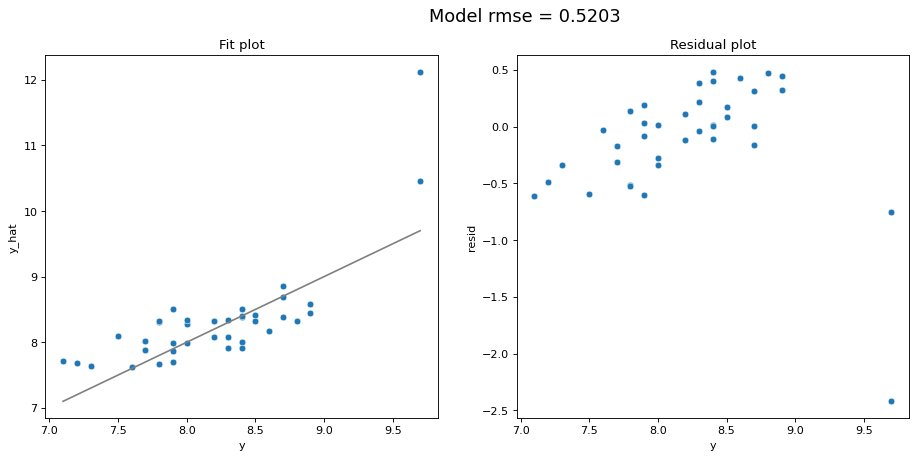

best param:  {'lasso__alpha': 0.01, 'polynomialfeatures__degree': 1}
best score:  0.38235067661304317
number of coefficients: 56
intercept ==  0.0


,y,y_hat,resid
106,8.4,8.384924,0.0
45,8.9,8.577038,0.3
158,7.2,7.685957,-0.5
63,7.9,8.503321,-0.6
135,9.7,10.456779,-0.8
66,8.3,7.918583,0.4
18,8.3,8.335011,-0.0
109,8.6,8.175420,0.4
141,7.3,7.634256,-0.3
7,8.2,8.319642,-0.1


In [ ]:
coefs = model.best_estimator_.named_steps["lasso"].coef_
Features = pd.DataFrame({'Feature':df_model_data.columns.drop('imdb_rating'), 'coefficients': coefs[1:] })
results_table

## Model Error Comparisons 
We assess the reliability of our models by calculating the Root Mean Squared Error (RMSE), interrogating the respective confidence intervals (CI), and comparing models against one another and their baseline equivalents. RMSE is calculate internally to each model, and CI is calculated independently (using ). This error information is captured for both the training and test data, in both full and reduced datasets. Calculations here are discussed in the next sections.


### Confidence Intervals for all models
Confidence intervals calculated here are included in the tables with RMSE results for brevity in the following two sub-sections. (It was not possible to delete this code from this notebook, and is not here for any academic reason)

In [ ]:
# Confidence intervals for reduced (engineered) data sets
# Lasso 
CI_Lasso_test = ml_functions.get_CI(results_table['y'], results_table['y_hat'] )
CI_Lasso_train = ml_functions.get_CI(results_table_train['y_train'], results_table_train['y_hat_train'] )
# Ridge
CI_Ridge_test = ml_functions.get_CI(poly_reg_ridge['y'], poly_reg_ridge['y_hat'] )
CI_Ridge_train = ml_functions.get_CI(poly_reg_ridge_train['y_train'], poly_reg_ridge_train['y_hat_train'] )
# Linear regression
CI_Lin_Reg_test = ml_functions.get_CI(lin_reg['y'], lin_reg['y_hat'] )
CI_Lin_Reg_train = ml_functions.get_CI(lin_reg_train['y_train'], lin_reg_train['y_hat_train'] )
# Poylynomial regression with no interactions
CI_Poly_noint_test = ml_functions.get_CI(poly_reg_noint['y'], poly_reg_noint['y_hat'] )
CI_Poly_noint_train = ml_functions.get_CI(poly_reg_noint_train['y_train'], poly_reg_noint_train['y_hat_train'] )
# Polynomial regression with interactions
CI_Poly_test = ml_functions.get_CI(poly_reg['y'], poly_reg['y_hat'] )
CI_Poly_train = ml_functions.get_CI(poly_reg_train['y_train'], poly_reg_train['y_hat_train'] ) 

# Confidence intervals for whole data set
# Lasso 
CI_Lasso_test_full = ml_functions.get_CI(results_table_full['y'], results_table_full['y_hat'] )
CI_Lasso_train_full = ml_functions.get_CI(results_table_train_full['y_train'], results_table_train_full['y_hat_train'] )
# Ridge 
CI_Ridge_test_full = ml_functions.get_CI(poly_reg_ridge_full['y'], poly_reg_ridge_full['y_hat'] )
CI_Ridge_train_full = ml_functions.get_CI(poly_reg_ridge_train_full['y_train'], poly_reg_ridge_train_full['y_hat_train'] )
# Linear regression
CI_Lin_Reg_test_full = ml_functions.get_CI(lin_reg_full['y'], lin_reg_full['y_hat'] )
CI_Lin_Reg_train_full = ml_functions.get_CI(lin_reg_train_full['y_train'], lin_reg_train_full['y_hat_train'] )
# Polynomial regression no interactions
CI_Poly_noint_test_full = ml_functions.get_CI(poly_reg_noint_full['y'], poly_reg_noint_full['y_hat'] ) 
CI_Poly_noint_train_full = ml_functions.get_CI(poly_reg_noint_train_full['y_train'], poly_reg_noint_train_full['y_hat_train'] )
# Polynomial regression
CI_Poly_test_full = ml_functions.get_CI(poly_reg_full['y'], poly_reg_full['y_hat'] )
CI_Poly_train_full = ml_functions.get_CI(poly_reg_train_full['y_train'], poly_reg_train_full['y_hat_train'] )


#### RMSE calculation in reduced dataset models:
The results are tabulated below for all of the models which have used the reduced dataset, which have had many features removed as part of the preprocessing

In [ ]:
# Create summary data frame for model data (features engineered)
model_data = [['linear_reg',rmse_train_lin_reg,CI_Lin_Reg_train,rmse_test_lin_reg,CI_Lin_Reg_train],
        ['poly_noint_reg',rmse_train_poly_reg_noint,CI_Poly_noint_train,rmse_test_poly_reg_noint,CI_Poly_noint_test],
        ['poly_reg', rmse_train_poly_reg,CI_Poly_train,rmse_test_poly_reg,CI_Poly_test], 
        ['lasso', lasso_rmse_train,CI_Lasso_train,lasso_rmse_test,CI_Lasso_test], 
        ['ridge',rmse_train_poly_reg_ridge,CI_Ridge_train,rmse_test_poly_reg_ridge,CI_Ridge_test]] 

model_data_summary = pd.DataFrame(model_data, columns = ['model', 'train_RMSE', 'train_RMSE_CI', 'test_RMSE', 'test_RMSE_CI']) 

model_data_summary

,model,train_RMSE,train_RMSE_CI,test_RMSE,test_RMSE_CI
0,linear_reg,0.0,"[0.14295985105068332, 0.22663173138162424]",0.637631,"[0.14295985105068332, 0.22663173138162424]"
1,poly_noint_reg,0.0,"[0.13961787432342443, 0.2226556142322073]",0.643452,"[0.1803697034543761, 0.5960750788172267]"
2,poly_reg,0.0,"[0.14295985105063358, 0.2266317313815745]",0.637631,"[0.17742128388122627, 0.5890929091061786]"
3,lasso,0.0,"[0.15497149769345536, 0.2454879540715279]",0.520286,"[0.16779727126958036, 0.5019627842558426]"
4,ridge,0.0,"[0.1509744688156157, 0.2347207490622968]",0.611648,"[0.17912584586134875, 0.5779777622463982]"


#### RMSE calculation in baseline (full dataset) models: 
The results are tabulated below for all of the models with no pre-processing. 

###### Note:
In our modelling, we use the baseline models primarily to provide a comparison for our RMSE values. We do not carry out our final modelling using the entire feature space in spite of a slightly improved RMSE as:

1. We aim to use as computationally efficient model as possible - therefore a model that employs feature reduction is preferred
2. We do not want to undermine our feature engineering steps 



In [ ]:
# Create summary data frame for whole data
model_data_full = [['linear_reg',rmse_train_lin_reg_full, CI_Lin_Reg_train_full, rmse_test_lin_reg_full, CI_Lin_Reg_train_full],
        ['poly_noint_reg',rmse_train_poly_reg_noint_full, CI_Poly_noint_train_full, rmse_test_poly_reg_noint_full, CI_Poly_noint_test_full],
        ['poly_reg', rmse_train_poly_reg_full, CI_Poly_train_full, rmse_test_poly_reg_full, CI_Poly_test_full], 
        ['lasso', lasso_rmse_train_full, CI_Lasso_train_full, lasso_rmse_test_full, CI_Lasso_test_full], 
        ['ridge', rmse_train_poly_reg_ridge_full, CI_Ridge_train_full, rmse_test_poly_reg_ridge_full, CI_Ridge_test_full]] 

model_data_summary_full = pd.DataFrame(model_data_full, columns = ['model', 'train_RMSE', 'train_RMSE_CI', 'test_RMSE', 'test_RMSE_CI']) 

model_data_summary_full

,model,train_RMSE,train_RMSE_CI,test_RMSE,test_RMSE_CI
0,linear_reg,0.0,"[0.05334542510607752, 0.09126592305724601]",0.775638,"[0.05334542510607752, 0.09126592305724601]"
1,poly_noint_reg,0.0,"[0.05235466664556533, 0.08751345099253478]",0.889433,"[0.21408629856171696, 0.7813370801859065]"
2,poly_reg,0.0,"[1.7370968183719121e-12, 2.706411805743506e-12]",1.238651,"[0.23083164207634327, 1.0442917612269853]"
3,lasso,0.0,"[0.10948062610872387, 0.16900711213849]",0.490460,"[0.1721177046539218, 0.48834951829099554]"
4,ridge,0.0,"[0.1764674430088074, 0.21838927305417632]",0.574062,"[0.2358754584540893, 0.6035642282839611]"


# Discussion & Conclusions


## Final Choice of model
Lasso model allows us to identify unimportant features in order to remove them from the model by giving them a zero value coefficient. Among the models tested, lasso regression was found to be the most accurate model with the lowest RMSE for both the full dataset, and the one with feature engineering applied (subset of features). The test RMSE for the full dataset was 0.49, while the test RMSE for the reduced dataset was 0.52. Eventhough, we can achieve a higher accuracy using the full dataset, we decided to persist with the reduced dataset given that we only improve the RMSE by .03. Additionally, maintaning the reduce dataset allows us to select only those variables that were most relevant to explain the imbd rating. In fact, it is always preferred to seek for a parsimonious model.
 

## Analysis of Coefficients and Recommendations
Feature coefficients are the way in which the model communicates the impact of each festure. Coefficients equal to zero indicate no impact. Positive coefficients indicate that a feature will increase imdb_rating, negative coefficients indicate that a feature will reduce imdb_rating. The following is a detailed breakdown, and all are given in descending order of importance. First, the chart below visualises the feature coefficients for our final model. Coefficients that are set to zero are those set to zero by lasso regularisation. Overall, there were 18 features recommended to be removed from the model.

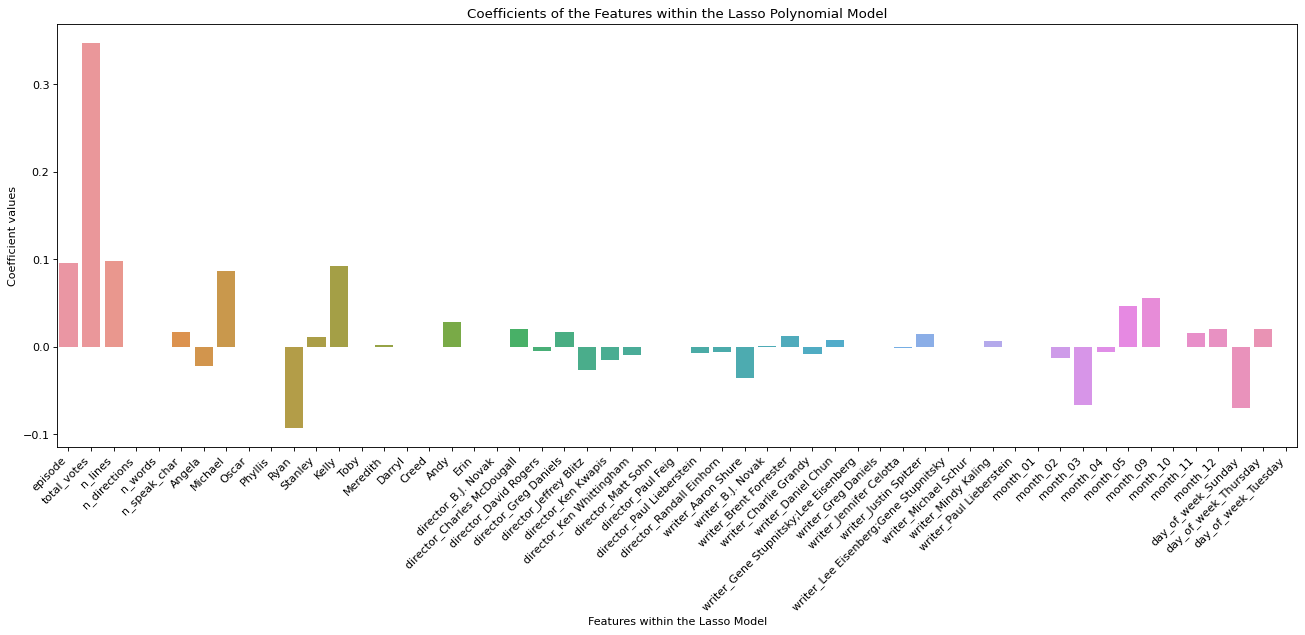

In [ ]:
ml_functions.features_overview(Features)

### Recommendations - things to include

The following recommendations are based on the highest feature coefficients.

- Total votes feature appears to have the most positive impact for improving the rating, as this the largest coefficient provided by the Lasso predictive model. However, is not a sensible or realistic recommendation given that NBC can not control the number of votes cast on IMDB. However, NBC may consider encouraging viewers to leave reviews to help with future prediction.
- The second most important feature is 'n_lines'. Therefore, we recommend to increase the number of spoken lines in the episode. It is important to clarify, that this does not necessarily means to increase the number of dialog words in episode, as 'n_words' feauture seems to don't have any impact on increasing the rating. In this way, the episode may include short but more constant lines between characters. In fact, the feature 'n_speaking_chars' has also low but also positive impact, thus the producers should design an episode with a high number of lines distributed across many characters.
- Models show that the greater the number of episode the best rating an episode will achieve. In this context, we recommend to release the episode by the end of season. The model states that ratings increase as episodes go on throughout a season. Given that NBC is looking to produce a one off special, this will not be possible to benefit from a season full of momentum of increasingly rated shows. If NBC could consider the idea, it would therefore be recommended that rather than NBC produce one single special edition, that a short special edition season was created, with the finale of this season expected to outperform all others.
- With respect to the characters, we recommend that additional to Dwight, Jim, Pam and Kevin, NBC should include Kelly, Michael and Andy, in the given order of importance. It is important to recall that Dwight, Jim, Pam and Kevin were removed from the train model as these appear in almost every episode and we wish to know which other character have a positive impact on increasing the rating. Producers must decide the cost of opportunity of increasing the number of characters, as 6 of them were eliminated from the model (with zero value coefficient), and increasing the speaking characters, which as stated befor might generate a positive but very small impact for the rating.
- The model indicates that airing the shows in September, May or December produces the most positive ratings on imdb (months stated in the order of importance) 
- In the same way, we recommend to release the episode on Thursdays. It is suggested that NBC shows the special edition episode on a Thursday as this day appears to have the most positive impact for increasing the show rating. There is no coefficient for viewing on a Tuesday, thus showing on Thursdays will have a marginal advantage. 
- Among Directors, Charles McDougall and/or Greg Daniels should direct or co-direct the special edition episode. Both have positive coefficients, and so both directors working on the episode would allow favourable characteristics of a special edition episode. The model results are reassuring again, as Greg Daniels has directed the 2 highest rated shows in the Office history (“Goodbye, Michael” in season 7, and “Finale” in Season 9). Evidently, NBC in the past  have used Greg Daniels to direct a successful episode.


### Recommendations - things to exclude

The following recommendations are based on the most negative feature coefficients

- NBC should not include Ryan and, to a lesser extent, Angela, as their inclusion might have an adverse affect on the rating of the episode. In fact, the negative impact of these characters is greater than the positive impact the NBC might achieve by increasing the number of different characters with spoken lines. Therefore, we recommend to remove these characters altogether.
- NBC should not air the special on Sundays as it is the day with the most negative impact for achieving an increase in the rating.
- The model suggests that airing the show between February and April results in less favourable rating. In particular, March is the month which NBC should definitely avoid as this is the month with the worst impact for our goal.
- Among the writers, we recommend to avoid Aaron Shure to be the writer's episode. It is important to clarify that even the negative impact could be really small it is still perjudicial to our aim. 
- In the same tenor, we recommend to avoid hiring the director Jefery Blitz, and to a lesser extent Ken Kwapis, as these seems to have a negative impact for the rating. 



## Analysis of confidence Intervals
A confidence interval (CI) indicates the range of values in which we expect to find 95% of our train or test error accordingly. A narrow CI indicates the data is very centred around one area, and indicates smaller error. Some of our comments regarding the results provided for CI are:

-   There is a higher variance in the test data which will contribute to the higher test confidence error: we can see that output ratings range from 7.6-12.1, while we know that the maximum in any of the training data will no surpass 10. If the model was to be capped to ratings no greater than 10, this would artificially reduce the confidence interval, and give a more reliable model. 
-   It is important to mention, that there are two ratings which can be thought as outliers, as these values are far from the rest of the ratings showed in the history. In particular, the test data includes these points, meaning they aren't included in the training data, thus when the model predicts for unknown data the test error will increase given that the these outliers were not  included in the train data. This should be considered when looking at the models with slightly higher Confidence Interval. 

-   The sample of data used to train and test the model is small and thus there is not enough data to make strong inference on. As a consequence, the range of the confidence interval will increase, as N is small and variance tends to increase. 

-   The CI for the full dataset is smaller as there is a smaller RMSE, and has been proven to be more predictive, this is expected from a wider depth of features in the small sample. 

#### One final note on the dataset, and possible further work
The dataset here is relatively small - 187 datapoints. If NBC had other shows which were comparable in genre and intended audience etc, this could be extended perhaps to improve reliability. Predictions and recommendations provided here would be greatly enhanced if it also included viewer ratings data (i.e how much the show was actually wached), as this ultimately is a better indicator of success than the imdb_rating alone and would give some idea of the proportion of the audience are voting. This could be an extension of the current work.
The current analysis also contains no information on cost of production of episodes, and we do not take this into account. If cost of production is an important factor (e.g. including more characters is likely more expensive) then more information would be needed on how costs are driven/calculated.

## 5. Convert Document

In [18]:
# !jupyter nbconvert --to markdown project1.ipynb # I dont think this one will work?
!jupyter nbconvert --to pdf project1.ipynb
# jupyter nbconvert --to pdf --TemplateExporter.exclude_input=True project1.ipynb
# jupyter nbconvert --to pdf --TemplateExporter.exclude_input=True  project1.ipynb

[NbConvertApp] Converting notebook project1.ipynb to pdf
[NbConvertApp] Support files will be in project1_files/
[NbConvertApp] Making directory ./project1_files
[NbConvertApp] Making directory ./project1_files
[NbConvertApp] Making directory ./project1_files
[NbConvertApp] Making directory ./project1_files
[NbConvertApp] Making directory ./project1_files
[NbConvertApp] Making directory ./project1_files
[NbConvertApp] Making directory ./project1_files
[NbConvertApp] Making directory ./project1_files
[NbConvertApp] Writing 95336 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 478200 bytes to project1.pdf


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8d54bbee-a4bc-40dc-a5f1-a0190c0e14b4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>